In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import os
import json
import cv2
import numpy as np
from PIL import Image 
from torchvision import models

base_path = "./Data_122824/"
tr_folder_path = os.path.join(base_path, "Glioma_MDC_2025_training")
te_folder_path = os.path.join(base_path, "Glioma_MDC_2025_test")

In [4]:
import os
import shutil
import cv2
import numpy as np

# Function to compute target statistics (mean and std in LAB color space) from a reference image
def get_reference_stats(src_folder):
    for root, _, files in os.walk(src_folder):
        for file in files:
            if file.lower().endswith('.jpg'):
                ref_path = os.path.join(root, file)
                ref_img = cv2.imread(ref_path)
                # Convert to LAB color space
                ref_lab = cv2.cvtColor(ref_img, cv2.COLOR_BGR2LAB).astype("float32")
                l, a, b = cv2.split(ref_lab)
                target_means = [np.mean(l), np.mean(a), np.mean(b)]
                target_stds  = [np.std(l),  np.std(a),  np.std(b)]
                print(f"Reference image: {ref_path}")
                print(f"Target means: {target_means}")
                print(f"Target stds:  {target_stds}")
                return target_means, target_stds
    raise ValueError("No jpg images found in the source folder.")

# Function to perform Reinhard normalization on a given image
def reinhard_normalization(img, target_means, target_stds):
    # Convert the image to LAB color space and cast to float for computation
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB).astype("float32")
    l, a, b = cv2.split(lab)
    
    # Compute source image statistics
    src_means = [np.mean(l), np.mean(a), np.mean(b)]
    src_stds  = [np.std(l),  np.std(a),  np.std(b)]
    
    # Normalize each channel: subtract source mean, scale by ratio of stds, then add target mean
    l_norm = ((l - src_means[0]) * (target_stds[0] / (src_stds[0] + 1e-8))) + target_means[0]
    a_norm = ((a - src_means[1]) * (target_stds[1] / (src_stds[1] + 1e-8))) + target_means[1]
    b_norm = ((b - src_means[2]) * (target_stds[2] / (src_stds[2] + 1e-8))) + target_means[2]
    
    lab_norm = cv2.merge([l_norm, a_norm, b_norm])
    # Clip values to valid range and convert back to uint8 before converting back to BGR
    lab_norm = np.clip(lab_norm, 0, 255).astype("uint8")
    norm_img = cv2.cvtColor(lab_norm, cv2.COLOR_LAB2BGR)
    return norm_img

# Function to process a folder recursively:
# Normalize jpg files and copy non-jpg files, preserving the directory structure.
def process_folder(src_folder, dst_folder, target_means, target_stds):
    for root, dirs, files in os.walk(src_folder):
        # Determine the corresponding destination directory
        rel_path = os.path.relpath(root, src_folder)
        dst_dir = os.path.join(dst_folder, rel_path)
        os.makedirs(dst_dir, exist_ok=True)
        
        for file in files:
            src_file = os.path.join(root, file)
            dst_file = os.path.join(dst_dir, file)
            if file.lower().endswith('.jpg'):
                img = cv2.imread(src_file)
                if img is None:
                    print(f"Warning: Could not read image {src_file}. Skipping.")
                    continue
                norm_img = reinhard_normalization(img, target_means, target_stds)
                cv2.imwrite(dst_file, norm_img)
            else:
                # For non-image files, simply copy the file.
                shutil.copy(src_file, dst_file)

# Base paths and folder names
base_path = "./Data_122824/"
tr_folder_path = os.path.join(base_path, "Glioma_MDC_2025_training")
te_folder_path = os.path.join(base_path, "Glioma_MDC_2025_test")

# Define output folders for the normalized data
new_tr_folder_path = os.path.join(base_path, "Glioma_MDC_2025_training_normalized")
new_te_folder_path = os.path.join(base_path, "Glioma_MDC_2025_test_normalized")

# Get target color statistics from the training folder (using the first jpg as reference)
target_means, target_stds = get_reference_stats(tr_folder_path)

# Process both training and test folders
process_folder(tr_folder_path, new_tr_folder_path, target_means, target_stds)
process_folder(te_folder_path, new_te_folder_path, target_means, target_stds)


Reference image: ./Data_122824/Glioma_MDC_2025_training/training0646.jpg
Target means: [np.float32(118.748245), np.float32(168.43445), np.float32(98.13275)]
Target stds:  [np.float32(33.633495), np.float32(6.4393244), np.float32(7.0086575)]


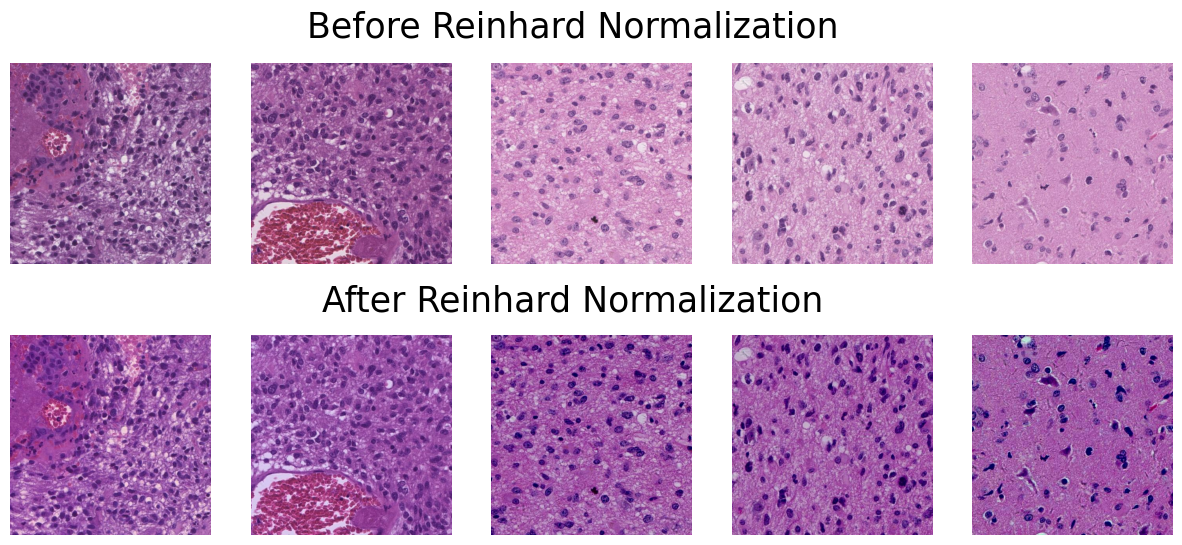

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def compare_preprocessing_images(before_image_paths, after_image_paths):
    """
    Plots 10 images in a 2x5 grid for comparison, with one title above the top row
    and one below the bottom row. Extra space is added between the titles and the images.
    
    Parameters:
    - before_image_paths: list of 5 strings representing the file paths for the "Before" images.
    - after_image_paths: list of 5 strings representing the file paths for the "After" images.
    """
    if len(before_image_paths) != 5 or len(after_image_paths) != 5:
        raise ValueError("Exactly 5 image paths for 'before' and 5 for 'after' are required.")
    
    # Create a 2x5 subplot figure with an increased figure height for spacing.
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    
    # Plot the 'Before' images on the top row.
    for i, path in enumerate(before_image_paths):
        img = mpimg.imread(path)
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
    
    # Plot the 'After' images on the bottom row.
    for i, path in enumerate(after_image_paths):
        img = mpimg.imread(path)
        axes[1, i].imshow(img)
        axes[1, i].axis('off')
    
    # Adjust layout to create extra space at the top and bottom.
    plt.subplots_adjust(top=0.8, bottom=0.2, hspace=0.3)
    
    # Add the row titles with vertical alignment adjustments:
    # For the top row, va='bottom' places the text just above the images.
    fig.text(0.5, 0.82, 'Before Reinhard Normalization', ha='center', va='bottom', fontsize=25)
    # For the bottom row, va='top' places the text just below the images.
    fig.text(0.5, 0.52, 'After Reinhard Normalization', ha='center', va='top', fontsize=25)
    
    plt.show()


# Example usage:
# image_list = ["before1.jpg", "before2.jpg", "before3.jpg", "before4.jpg", "before5.jpg",
#               "after1.jpg", "after2.jpg", "after3.jpg", "after4.jpg", "after5.jpg"]
# compare_preprocessing_images(image_list)

image_list_before = ["Data_122824/Glioma_MDC_2025_training/training0001.jpg", "Data_122824/Glioma_MDC_2025_training/training0002.jpg", "Data_122824/Glioma_MDC_2025_training/training0003.jpg", "Data_122824/Glioma_MDC_2025_training/training0004.jpg", "Data_122824/Glioma_MDC_2025_training/training0005.jpg"]
image_list_after = ["Data_122824/Glioma_MDC_2025_training_normalized/training0001.jpg", "Data_122824/Glioma_MDC_2025_training_normalized/training0002.jpg", "Data_122824/Glioma_MDC_2025_training_normalized/training0003.jpg", "Data_122824/Glioma_MDC_2025_training_normalized/training0004.jpg", "Data_122824/Glioma_MDC_2025_training_normalized/training0005.jpg"]

compare_preprocessing_images(image_list_before,image_list_after)